In [1]:
from utils.command_handler import ScriptParser, Command
import numpy as np
import cv2
import imutils
from PIL import Image, ImageTk, ImageFont, ImageDraw, ImageChops
from matplotlib import pyplot as plt
from external_functions.base_functions import decide_smelting, standard_map, decide_smelting
import os
import time
import pyvisa
import logging

logger = logging.getLogger(__name__)

In [2]:
im_p = cv2.imread("map_plus.png")
im_m = cv2.imread("map_minus.png")
mapka = standard_map(im_p, im_m)

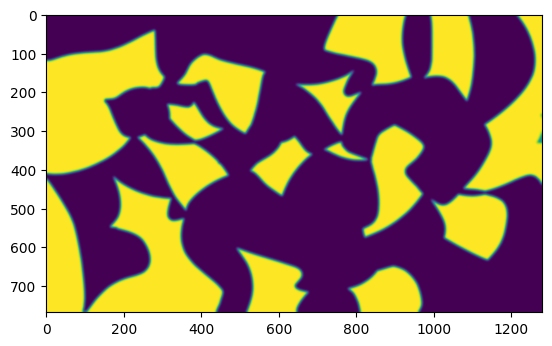

In [3]:
plt.imshow(mapka)

In [5]:
# decide_smelting(mapka, 1)

In [6]:
from utils.command_handler import Command, ScriptParser, parse_command

path = "custom_scripts/base_melt.scrpt"
scr = ScriptParser()
script_lines = scr.load_script(path)
scr.parse(script_lines)

In [7]:
script_lines

['new_block{',
 'image1 = load_image1()',
 'sleep(1)',
 'image2 = load_image2()',
 'sleep(1)',
 'mapka = exec_custom(standard_map, image1, image2)',
 'mapka_rgb = exec_custom(map_to_image, mapka, 1)',
 '}',
 'columns = %arg01',
 'rows = %arg02',
 'iterations = 0',
 'loop_count = 999',
 'loop(loop_count){',
 '    display_alt_image(mapka_rgb)',
 '    sleep(1)',
 '    reset_alt_image()',
 '    sleep(2)',
 '    iterations += 1',
 '    if(iterations == 3){',
 '        exit_loop()',
 '    }',
 '}']

In [9]:
from utils.utils import print_command


print_command(scr.commands)

      new_block()
      operator(image1, =, load_image1)
      sleep(1)
      operator(image2, =, load_image2)
      sleep(1)
      operator(mapka, =, exec_custom, standard_map, image1, image2)
      operator(mapka_rgb, =, exec_custom, map_to_image, mapka, 1)
   operator(columns, =, %arg01)
   operator(rows, =, %arg02)
   operator(iterations, =, 0)
   operator(loop_count, =, 999)
      loop(loop_count)
      display_alt_image(mapka_rgb)
      sleep(1)
      reset_alt_image()
      sleep(2)
      operator(iterations, +=, 1)
         if(iterations, ==, 3)
         exit_loop()
      restart_block()


In [21]:
def load_script(path: str) -> list[str]:
    with open(path, "r") as f:
        lines = f.readlines()
    return lines

def req_construct_script(script_lines, path):
    with open(path, "r") as f:
        lines = f.readlines()
    for line in lines:
        if "SCRPT:" in line:
            fname = line.replace("SCRPT:", "").strip()
            script_lines.append("{")
            req_construct_script(script_lines, f"custom_scripts/{fname}")
            script_lines.append("}")
        else:
            script_lines.append(line)
    return script_lines



In [22]:
path = "custom_scripts/example_script02.scrpt"
lines = req_construct_script([], path)

In [23]:
lines

['var_a = 1\n',
 'if(var_a == 1){\n',
 '{',
 'image1 = load_image1()\n',
 'sleep(1)\n',
 'image2 = load_image2()\n',
 'sleep(1)\n',
 'mapka = exec_custom(standard_map, image1, image2)\n',
 'mapka_rgb = exec_custom(map_to_image, mapka, 1)',
 '}',
 '    display_alt_image(mapka_rgb)\n',
 '    sleep(8)\n',
 '    reset_alt_image()\n',
 '}']

In [2]:
rm = pyvisa.ResourceManager()

In [3]:
inst = rm.open_resource('USB0::0x1AB1::0x0643::DG8A220800267::INSTR')

In [4]:
inst.query("*IDN?")

'Rigol Technologies,DG812,DG8A220800267,00.02.02.00.00 \n'

In [5]:
inst.write(':SOUR1:APPL:SQU 2000,5,2.5,0')

30

In [8]:
inst.close()

In [7]:

rm = pyvisa.ResourceManager()
inst = rm.open_resource('USB0::0x1AB1::0x0643::DG8A220800267::INSTR')
if inst.query("*IDN?")[:18] == 'Rigol Technologies':
    # rigol = inst
    inst.write(':SOUR1:APPL:SQU 2000,5,2.5,0')

In [18]:
def replace_variables(anim_str, variables):
    for n in range(0, len(variables)):
        var_name = 'var%d'%n
        anim_str = anim_str.replace(var_name, '%2.2f'%variables[n])
    return anim_str


def draw_parametric_animation(anim_str, posx, posy, rota, size, ctime, variables = []):
    canvas = np.zeros((448, 800, 3), np.uint8)
    # print('PARANIM STR:', anim_str)
    
    # scale parameter is from textfile, size is from brush size 
    anim_str = replace_variables(anim_str, variables)
    for obj in anim_str.split('OBJECT')[1:]:
        splitted = obj.splitlines()

        line1 = splitted[0].split(' ')
        typ = line1[1]

        # init parameters
        cx = 0
        cy = 0
        scale = 1

        for line in splitted[1:]:
            line_splt = line.split(' ')
#             line_splt = replace_variables(line_splt, variables)
            if eval(line_splt[0]) <= ctime:
                if eval(line_splt[2]) >= ctime:
                    total_time = eval(line_splt[2])-eval(line_splt[0])
                    completness = (ctime-eval(line_splt[0]))/total_time
                    if line_splt[3] == 'MOVE':
                        change_x = eval(line_splt[7])-eval(line_splt[4])
                        change_y = eval(line_splt[8])-eval(line_splt[5])
                        cx = int(eval(line_splt[4]) + change_x*completness)
                        cy = int(eval(line_splt[5]) + change_y*completness)
                        cx = int(cx*size/100 + 800/2)
                        cy = int(cy*size/100 + 448/2)
                    if line_splt[3] == 'SCALE':
                        change_s = eval(line_splt[6])-eval(line_splt[4])
                        scale = eval(line_splt[4]) + change_s*completness

        if line1[1] == 'rectangle':
            stp = (int(cx-0.5*eval(line1[2])*scale*size/100), int(cy-0.5*eval(line1[3])*scale*size/100))
            enp = (int(cx+0.5*eval(line1[2])*scale*size/100), int(cy+0.5*eval(line1[3])*scale*size/100))
            clr = (eval(line1[4]), eval(line1[4]), eval(line1[4]))
            canvas = cv2.rectangle(canvas, stp, enp, clr, -1)
            
        if line1[1] == 'ellipse':
            axes = (int(eval(line1[2])*scale*size/100), int(eval(line1[3])*scale*size/100))
            clr = (int(line1[5]), int(eval(line1[5])), int(eval(line1[5])))
            canvas = cv2.ellipse(canvas, (cx, cy), axes, 0, 0, 360, clr, -1)

        # now rotate
        canvas_rot = imutils.rotate(canvas, rota)

        # now offset
        pil_img = Image.fromarray(canvas_rot)
        pil_img2 = ImageChops.offset(pil_img, int(posy-800/2), int(posx-448/2))
        canvas_done = np.array(pil_img2)

    return canvas_done

In [19]:
path = "d:/Katalog 1/Projekty/Mikroskop 3.0/laser_microscope/old_soft/mikroskop1/parametric_animations/shining-moon3.anim"
with open(path, "r") as f:
    cnt = f.read()

cnt

'OBJECT ellipse 100 100 0 255\n0.00 -> 0.10 MOVE 0 0 -> 0 0\n0.10 -> 1.00 MOVE 0 0 -> 0 0\n0.10 -> 1.00 SCALE 1.00 -> 1.30\nOBJECT ellipse 100 100 0 0\n0.00 -> 0.10 MOVE -100 0 -> -100 0\n0.10 -> 1.00 MOVE -100 0 -> -25 0\n0.00 -> 0.10 SCALE 0.20 -> 0.20\n0.10 -> 1.00 SCALE 0.20 -> 1.5'

In [31]:
n = 0
inc = 0.1

1.00


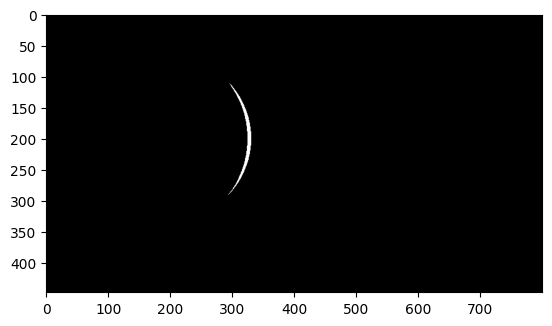

In [42]:
img = draw_parametric_animation(cnt, 200, 200, 0, 100, n)
print(f"{n:.2f}")
n += inc

plt.imshow(img)

In [3]:
def print_command(cmd, nest = 0):
    if type(cmd) == Command:
        print(f"{"   "*nest}{cmd.get_format()}")
    elif type(cmd) == list:
        for c in cmd:
            print_command(c, nest=nest+1)

In [4]:
print_command(scr.commands)

   laser_on()
   set_laser_duty(12)
   operator(var_a, =, 12)
      if(var_a, ==, 12)
      set_laser_duty(5)
   operator(var_x, =, 0)
      loop(4)
      laser_on()
      wait(2)
         if(var_a, >, 12)
         set_laser_duty(1)
      laser_off()
      operator(var_x, +=, 1)
      restart_block()


In [12]:
scr.commands

In [2]:
import os
import time
from tkinter import messagebox

import cv2
import numpy as np
from utils.consts import LabJackConsts
from utils.utils import thread_execute
from PIL import Image, ImageTk

import clr
from ctypes import *
from devices.TC300_COMMAND_LIB import *
import logging


# Add References to .NET libraries
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.DeviceManagerCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.GenericMotorCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.Benchtop.DCServoCLI.dll.")
clr.AddReference(
    "C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.IntegratedStepperMotorsCLI.dll."
)
clr.AddReference(
    "C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.IntegratedStepperMotorsUI.dll"
)

# I dont know how it works, ask thorlabs
from Thorlabs.MotionControl.DeviceManagerCLI import *  # type: ignore
from Thorlabs.MotionControl.GenericMotorCLI import *  # type: ignore
from Thorlabs.MotionControl.Benchtop.DCServoCLI import *  # type: ignore
from Thorlabs.MotionControl.IntegratedStepperMotorsUI import *  # type: ignore
from Thorlabs.MotionControl.IntegratedStepperMotorsCLI import *  # type: ignore
from System import Decimal  # Required for real units  # type: ignore

In [4]:
SERIAL_NO = "55520124"

In [16]:
DeviceManagerCLI.BuildDeviceList()  # type: ignore

In [17]:
labjack = LabJack.CreateLabJack(SERIAL_NO)

In [18]:
labjack.Connect(SERIAL_NO)

In [19]:
labjack.GetDeviceInfo()

In [20]:
labjack.StartPolling(250)
labjack.EnableDevice()

In [22]:
labjack.LoadMotorConfiguration(SERIAL_NO)
labjack.InitializeWaitHandler()

<System.Action[UInt64] object at 0x0000028B58D07F40>

In [23]:
work_done = labjack.InitializeWaitHandler()
labjack.MoveTo(Decimal(33), work_done)

DeviceSettingsException: Device settings not initialized
   at Thorlabs.MotionControl.GenericMotorCLI.AdvancedMotor.GenericAdvancedMotorCLI.VerifyMotorSettings(Int32 functionDepth)
   at Thorlabs.MotionControl.GenericMotorCLI.AdvancedMotor.GenericAdvancedMotorCLI.VerifyDeviceMovement(Int32 functionDepth, VerifyMovementFlags flags)
   at Thorlabs.MotionControl.GenericMotorCLI.AdvancedMotor.GenericAdvancedMotorCLI.MoveTo(Decimal position, Action`1 callback)

In [15]:

labjack.StopPolling()
labjack.Disconnect()

In [1]:
# from inputs import get_gamepad
import math
import clr
import subprocess
from ctypes import *
import time

# Add References to .NET libraries
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.DeviceManagerCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.GenericMotorCLI.dll")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.Benchtop.DCServoCLI.dll.")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.IntegratedStepperMotorsCLI.dll.")
clr.AddReference("C:\\Program Files\\Thorlabs\\Kinesis\\Thorlabs.MotionControl.IntegratedStepperMotorsUI.dll")

from Thorlabs.MotionControl.DeviceManagerCLI import *
from Thorlabs.MotionControl.GenericMotorCLI import *
from Thorlabs.MotionControl.Benchtop.DCServoCLI import *
from Thorlabs.MotionControl.IntegratedStepperMotorsUI import *
from Thorlabs.MotionControl.IntegratedStepperMotorsCLI import *
from System import Decimal  # Required for real units

In [ ]:
DeviceManagerCLI.BuildDeviceList()
# create new device
serial_no = "55520124"  # Replace this line with your device's serial number
device = BenchtopDCServo.CreateBenchtopDCServo(serial_no)

In [3]:
device

In [1]:
from pylablib.devices import Thorlabs

In [2]:
Thorlabs.list_kinesis_devices()

[('55520124', 'Kinesis K10CR2 Rotary Stage'),
 ('101507134', 'Integrated XY Stage'),
 ('37009479', 'APT Filter Flipper')]

In [3]:
flipper = Thorlabs.kinesis.MFF("37009479")

c:\Users\Laser\Documents\new_microscope\laser_microscope\.venv\Lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:230: UserWarning: model number MFF002 doesn't match the device ID prefix 37(MFF10.)
  warnings.warn("model number {} doesn't match the device ID prefix {}({})".format(model_no,port,port_model_no))


In [4]:
flipper.move_to_state(1)

In [5]:
flipper.get_state()

1

In [23]:
stage.move_by(1000)

In [6]:
stage.move_to(100000)